# Neural network

Importing packages.

In [0]:
import pandas as pd
import numpy as np
import math
from scipy.special import expit as sigmoid
from scipy import linalg
import matplotlib.pyplot as plt

Getting data from irisdata.csv.

In [0]:
def getdata():
  global X, Y, m, n, K
  K = 3
  data = pd.read_csv("irisdata.csv")
  X = data[["sepal length", "sepal width", "petal length", "petal width"]].to_numpy()
  m = X.shape[0]
  X = np.append(np.ones((m,1)), X, axis=1)
  Y = np.zeros((m,K))
  for i in range(m):
    if data["type"][i] == "Iris-setosa":
      Y[i][0] = 1
    if data["type"][i] == "Iris-versicolor":
      Y[i][1] = 1
    if data["type"][i] == "Iris-virginica":
      Y[i][2] = 1
  n = X.shape[1]

Creating the training set, cross-validation set and test set. Randomly shuffles the data to get iris types distributed (on average) evenly in the 3 sample sets. This introduces randomness in the output, i.e. I will get different learned parameters and accuracies when running the algorithm multiple times. This randomness can be substantial due to the small sample size.

In [0]:
def createsets():
    global X, Y, Xtrain, Ytrain, Xcv, Ycv, Xtest, Ytest, m, n, K, mtrain, mcv, mtest
    randperm = np.random.permutation(range(m))
    X = X[randperm, :]
    Y = Y[randperm, :]
    [mtrain, mcv] = [math.floor(2/3*m), math.floor(m/6)]
    mtest = m-mtrain-mcv
    Xtrain = X[0:mtrain, :]
    Ytrain = Y[0:mtrain, :]
    Xcv = X[mtrain:mtrain+mcv, :]
    Ycv = Y[mtrain:mtrain+mcv, :]
    Xtest = X[mtrain+mcv:m, :]
    Ytest = Y[mtrain+mcv:m, :]

Random initialisation of parameters for symmetry breaking.

In [0]:
def thetainit():
    global num_params
    epsilon = 0.001
    num_params = hidden_layer_size*(n+K+1)
    THETA = np.random.rand(num_params)*2*epsilon-epsilon
    return THETA

Implementing forward propagation algorithm.

In [0]:
def forwardprop(X, Theta1, Theta2):
    a2 = sigmoid(Theta1@X.T)
    a2 = np.vstack((np.ones((1, X.shape[0])), a2))
    a3 = sigmoid(Theta2@a2)
    return a3.T

Calculating cost.

In [0]:
def cost(THETA):
    Theta1 = THETA[0 : hidden_layer_size*n].reshape(hidden_layer_size, n)
    Theta2 = THETA[hidden_layer_size*n : hidden_layer_size*n + K*(hidden_layer_size+1)].reshape(K, hidden_layer_size+1)
    cost = -1/mtrain * sum(sum(np.multiply(Ytrain, np.log(forwardprop(Xtrain, Theta1, Theta2))) + np.multiply(1-Ytrain, np.log(1-forwardprop(Xtrain, Theta1, Theta2)))))
    return cost

Implementing backpropagation algorithm (to calculate the gradient of the cost function).

In [0]:
def gradient(X, Y, THETA, Lambda):
  Theta1 = THETA[0 : hidden_layer_size*n].reshape(hidden_layer_size, n)
  Theta2 = THETA[hidden_layer_size*n : hidden_layer_size*n + K*(hidden_layer_size+1)].reshape(K, hidden_layer_size+1)
  Delta1 = np.zeros((hidden_layer_size, n))
  Delta2 = np.zeros((K, hidden_layer_size+1))
  for i in range(mtrain):
    a1 = X[i,:].reshape(n,1)
    a2 = sigmoid(Theta1@a1)
    a2 = np.vstack((np.ones((1, 1)), a2))
    a3 = sigmoid(Theta2@a2)
    delta3 = a3-Y[i,:].reshape(K,1)
    delta2 = np.multiply(Theta2.T@delta3, np.multiply(a2, 1-a2))
    delta2 = delta2[1:]
    Delta1 += delta2@(a1.T)
    Delta2 += delta3@a2.T
  D1 = 1/m * Delta1
  D2 = 1/m * Delta2
  return np.concatenate((D1.ravel(),  D2.ravel()))

Implementing batch gradient descent algorithm.

In [0]:
def gradient_descent(X, Y, THETA_0, Lambda, Alpha, num_iters, calculate_cost):
  global cost_history
  THETA = THETA_0
  for _ in range(num_iters):
    if calculate_cost:
      cost_history.append(cost(THETA))
    THETA = THETA - Alpha*gradient(X, Y, THETA, Lambda)
  return THETA

Calculate output layer activations and make predictions.

In [0]:
def makepredictions(Theta1, Theta2):
  output_activations = forwardprop(X, Theta1, Theta2)
  output = np.zeros((m, K))
  for i in range(m):
    for j in range(K):
      output[i,j] = int(output_activations[i,j]==np.amax(output_activations[i,:]))
  return output

Evaluate prediction accuracies.

In [0]:
def evaluate(Theta1, Theta2, fitted_lambda):
  output = makepredictions(Theta1, Theta2)
  train_mistakes = 0
  cv_mistakes = 0
  test_mistakes = 0
  for i in range(m):
    if (output[i, :] != Y[i, :]).any():
      if i in range(mtrain):
        train_mistakes += 1
      if i in range(mtrain, mtrain+mcv):
        cv_mistakes += 1
      if i in range(mtrain+mcv, m):
        test_mistakes += 1
  train_accuracy = 1-train_mistakes/mtrain
  cv_accuracy = 1-cv_mistakes/mcv
  test_accuracy = 1-test_mistakes/mtest
  if fitted_lambda:
    print("Training set accuracy: ", train_accuracy)
    print("Cross-validation set accuracy: ", cv_accuracy)
    print("Test set accuracy: ", test_accuracy)
  else:
    return cv_accuracy

Running the neural network algorithm.

In [35]:
getdata()
createsets()
hidden_layer_size = 3
cost_history = []
Lambda = 0
Alpha = 0.1
num_iters = 5000
THETA_0 = thetainit()
THETA = gradient_descent(Xtrain, Ytrain, THETA_0, Lambda, Alpha, num_iters, True)
Theta1 = THETA[0 : hidden_layer_size*n].reshape(hidden_layer_size, n)
Theta2 = THETA[hidden_layer_size*n : hidden_layer_size*n + K*(hidden_layer_size+1)].reshape(K, hidden_layer_size+1)
evaluate(Theta1, Theta2, True)

Training set accuracy:  0.97
Cross-validation set accuracy:  1.0
Test set accuracy:  1.0


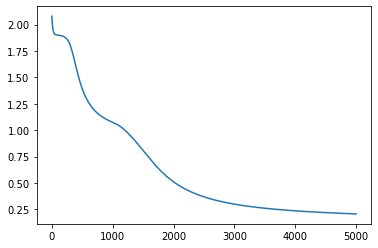

In [36]:
plt.plot(cost_history)